<a href="https://colab.research.google.com/github/pabloac31/TFG/blob/master/adversarial_attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/pabloac31/TFG.git
%cd TFG

Cloning into 'TFG'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 67 (delta 13), reused 9 (delta 4), pack-reused 41
Unpacking objects: 100% (67/67), done.
/content/TFG


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import tensorflow as tf
import torch

import matplotlib.pyplot as plt
import numpy as np
import time
import math

from PIL import Image
import torchvision.transforms.functional as TF

from tqdm import tqdm as pbar

# https://github.com/huyvnphan/PyTorch-CIFAR10
from cifar10_models import *
from utils_cifar10 import *
from adversarial_methods import *

In [0]:
iv3 = inception_v3(pretrained=True)

In [5]:
# Define what device we are using
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [0]:
test_loader = testloader('./data', 256)

Files already downloaded and verified


In [0]:
test_model(iv3, device, test_loader)

100%|██████████| 40/40 [00:14<00:00,  2.84it/s]


0.9541

In [22]:
adv_loader = testloader('./data', 1)

Files already downloaded and verified


In [0]:
def test_fgsm(img, epsilon):
  
  model = iv3.to(device).eval()
  
  image = Image.open(img)
  x = TF.to_tensor(image)

  for channel in range(3):
    x[channel] = (x[channel] - mean[channel]) / std[channel]

  x = x.unsqueeze_(0).to(device)

  label = torch.tensor([1]).to(device)

  x.requires_grad = True

  y = model(x)
  init_pred = y.max(1, keepdim=True)[1]
  print("Original image prediction: ", init_pred.item())

  if init_pred.item() != label.item():
    print("Image misclassified...")
    return

  # Calculate the loss
  loss = F.nll_loss(y, label)

  # Zero all existing gradients
  model.zero_grad()

  # Calculate gradients of model in backward pass
  loss.backward()

  # Collect datagrad
  x_grad = x.grad.data

  # Call FGSM attack
  adv_x = fgsm(x, epsilon, x_grad)  #  +-28 pixeles en [0,255]

  y_adv = model(adv_x)
  adv_pred = y_adv.max(1, keepdim=True)[1]
  print("Adversarial image prediction: ", adv_pred.item())

  if adv_pred.item() == label.item():
    print("Attack failed... try with a greater epsilon")

  else:
    print("Succesful attack!")

  adv_ex = adv_x.squeeze().detach().cpu().numpy()

  for channel in range(3):
    adv_ex[channel] = adv_ex[channel]*std[channel] + mean[channel]

  adv_ex = np.transpose(adv_ex, (1,2,0))

  plt.imshow(np.asarray(image))
  plt.title('Original image')
  plt.show()
  plt.imshow(adv_ex)
  plt.title('Adversarial image')
  plt.show()

Original image prediction:  1
Adversarial image prediction:  6
Succesful attack!


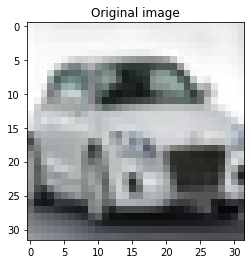

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


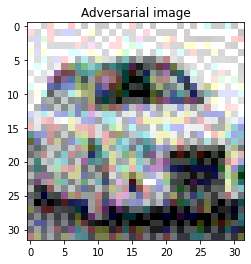

In [115]:
test_fgsm('./img1.png', 0.56)

In [0]:
acc, adv_examples = test_fgsm(iv3, device, adv_loader, 0.007, iters=1)

In [0]:
def full_test_fgsm(model, device, test_loader, epsilon, iters=10000):
  
  # Initialize the network and set the model in evaluation mode. 
  model = model.to(device).eval()

  # Accuracy counter
  correct = 0
  confidence = 0
  total_time = 0
  robustness = 0
  adv_examples = []

  i = 0

  # Loop all examples in test set
  for data, target in pbar(test_loader):
    if i >= iters:
      break
    i += 1

    # Send the data and label to the device
    data, target = data.to(device), target.to(device)
  
    # Set requires_grad attribute of tensor. Important for Attack
    data.requires_grad = True

    # Forward pass the data through the model
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

    # If the initial prediction is wrong, dont botter attacking
    if init_pred.item() != target.item():
      continue

    # Calculate the loss
    loss = F.nll_loss(output, target)

    # Zero all existing gradients
    model.zero_grad()

    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect datagrad
    data_grad = data.grad.data

    # Call FGSM attack
    time_ini = time.time()
    perturbed_data = fgsm(data, epsilon, data_grad)
    time_end = time.time()
    total_time += time_end-time_ini

    # Update model robustness
    delta = math.sqrt(32*32*3*epsilon**2)  # fgsm has a fixed delta(f,x) robustness
    im_np = data.squeeze().detach().cpu().numpy()
    robustness += delta / np.linalg.norm(im_np.flatten(), ord=2)

    # Re-classify the perturbed image
    output = model(perturbed_data)

    # Check for success
    final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    confidence += F.softmax(output, dim=1).max(1, keepdim=True)[0].item()  # adv. confidence
    if final_pred.item() == target.item():
      correct += 1
    else:
      # Save some adv examples for visualization later
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), im_np, adv_ex) )

  # Calculate final accuracy for this epsilon
  final_acc = correct / float(iters)  # len(test_loader)
  avg_confidence = confidence / float(iters)
  avg_time = total_time / float(iters)
  model_robustness = robustness / float(iters)
  print("Epsilon: {}\nTest Accuracy = {} / {} = {}\nAverage confidence = {}\nAverage time = {}\nAverage magnitude of perturbations = {}\nModel robustness = {}"
    .format(epsilon, correct, iters, final_acc, avg_confidence, avg_time, delta, model_robustness))  # len(test_loader)

  # Return the accuracy and adversarial examples
  return final_acc, adv_examples

In [0]:
def plot_examples(epsilon, examples, mean, std):
  #cnt = 0
  #plt.figure(figsize=(8,10))
  for j in range(len(examples)):
    #cnt += 1
    #plt.subplot(len(examples), 2, cnt)
    #plt.xticks([], [])
    #plt.yticks([], [])
    #if j == 0:
      #plt.ylabel("Eps: {}".format(epsilon), fontsize=14)
    orig,adv,im,ex = examples[j]
    
    for channel in range(3):
      im[channel] = im[channel]*std[channel] + mean[channel]
      ex[channel] = ex[channel]*std[channel] + mean[channel]

    im = np.transpose(im, (1,2,0))
    ex = np.transpose(ex, (1,2,0))

    plt.title("{} -> {}".format(orig, adv))
    plt.imshow(im, cmap="gray")
    plt.show()
    plt.imshow(ex, cmap="gray")
    plt.show()
  #plt.tight_layout()
  #plt.show()

In [0]:
def clamp_norm(img, inf, sup):
  mean, std = [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]
  im = img.detach().cpu().numpy()
  for channel in range(3):
    lim_inf = (inf-mean[channel]) / std[channel]
    lim_sup = (sup-mean[channel]) / std[channel]
    for i, arr in enumerate(im[0][channel]):
      for j, pixel in enumerate(arr):
        if pixel < lim_inf:
          im[0][channel][i][j] = lim_inf
        elif pixel > lim_sup:
          im[0][channel][i][j] = lim_sup
  return (torch.from_numpy(im).to(device))

In [0]:
def fgsm(image, epsilon, data_grad):
  # Collect the element-wise sign of the data gradient
  sign_data_grad = data_grad.sign()
  # Create the perturbed image by adjusting each pixel of the input image
  perturbed_image = image + epsilon*sign_data_grad
  # Adding clipping to maintain [0,1] range
  perturbed_image = clamp_norm(perturbed_image, 0, 1)
  # Return the perturbed image
  return perturbed_image

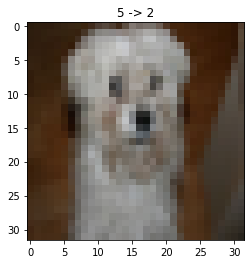

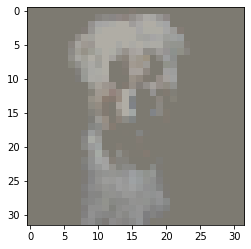

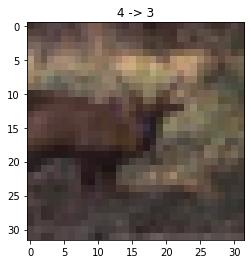

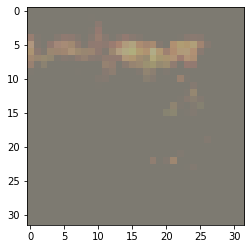

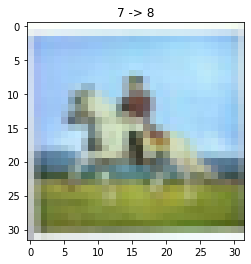

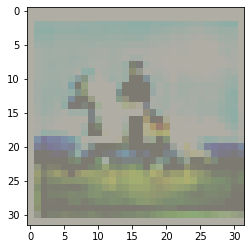

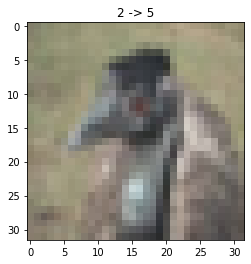

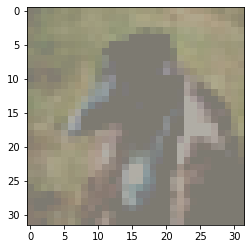

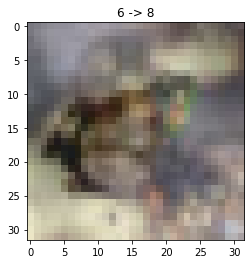

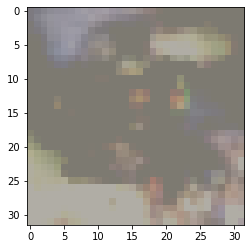

In [0]:
plot_examples(0.1, adv_examples, [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])